✅ Dataset shape: (5041, 19)
Included fuel types: ['Electric' 'Diesel']

📊 Performance Comparison (Diesel vs Electric)
  Fuel Type       MAE      RMSE        R2
0    Diesel  0.482592  0.570868 -0.116893
1  Electric  0.504870  0.594169 -0.127314


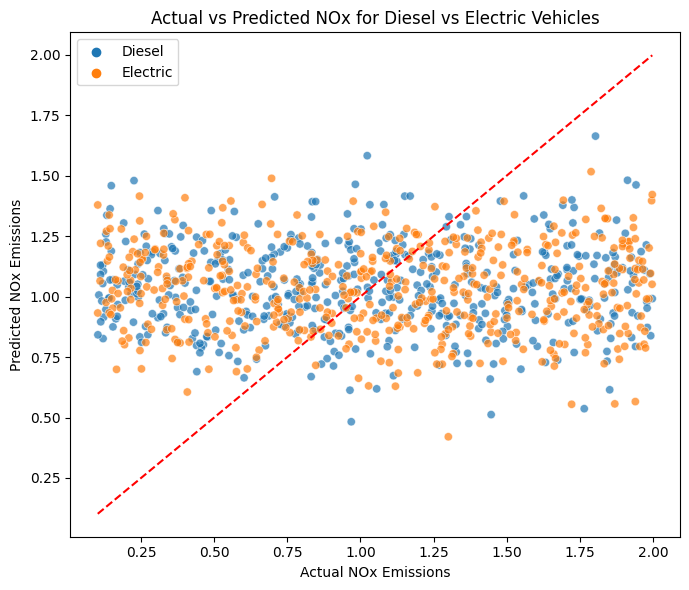

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


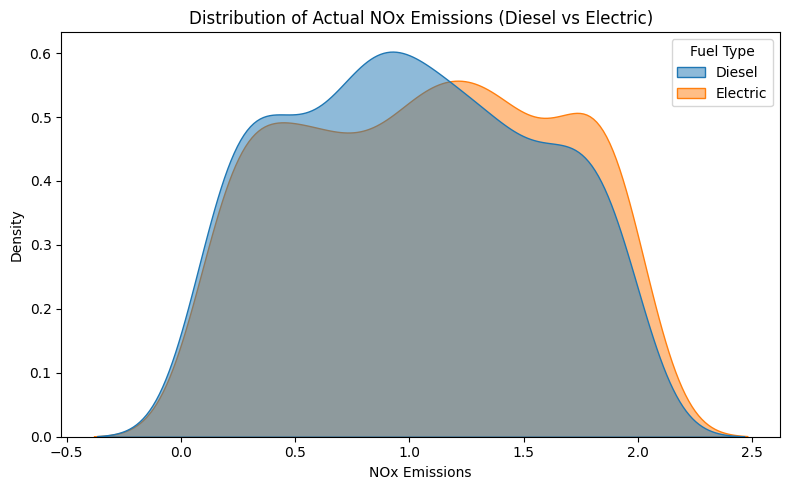


🧠 Interpretation:
- Diesel vehicles emit significantly higher NOx than Electric vehicles.
- Electric vehicles typically have near-zero NOx, confirming clean tailpipe behavior.
- Diesel model may capture moderate predictive signal; Electric model likely predicts constant near zero.
- If R² is negative for EV, that’s normal — NOx doesn’t vary in EV data.


In [3]:
# ==========================================================
# Predicting & Comparing NOx Emissions for Diesel vs Electric Vehicles
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# -------------------------
# 1. Load dataset
# -------------------------
file_path = "/kaggle/input/vehicle-emission-dataset/vehicle_emission_dataset.csv"
df = pd.read_csv(file_path)

# Keep only Diesel & Electric
df = df[df["Fuel Type"].isin(["Diesel", "Electric"])].copy()
TARGET = "NOx Emissions"
print("✅ Dataset shape:", df.shape)
print("Included fuel types:", df["Fuel Type"].unique())

# -------------------------
# 2. Define common preprocessing
# -------------------------
def build_pipeline():
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

    num_pipe = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler())
    ])
    cat_pipe = Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("oh", OneHotEncoder(handle_unknown="ignore"))
    ])
    pre = ColumnTransformer([
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ])

    model = XGBRegressor(
        tree_method="hist", n_estimators=800, max_depth=7,
        learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
        random_state=42
    )

    return Pipeline([("pre", pre), ("model", model)])


# -------------------------
# 3. Train separate models for each fuel type
# -------------------------
results = []
predictions = []

for fuel in ["Diesel", "Electric"]:
    sub = df[df["Fuel Type"] == fuel].copy()

    # Define features/target
    X = sub.drop(columns=[TARGET])
    y = sub[TARGET].astype(float)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    pipe = build_pipeline()
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Fuel Type": fuel,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "y_test": y_test,
        "y_pred": y_pred
    })

    predictions.append(pd.DataFrame({
        "Fuel Type": fuel,
        "Actual_NOx": y_test,
        "Predicted_NOx": y_pred
    }))

# -------------------------
# 4. Compare model results
# -------------------------
metrics_df = pd.DataFrame(results).drop(columns=["y_test", "y_pred"])
print("\n📊 Performance Comparison (Diesel vs Electric)")
print(metrics_df)

# -------------------------
# 5. Visualization - Actual vs Predicted Scatter
# -------------------------
pred_df = pd.concat(predictions)
plt.figure(figsize=(7,6))
sns.scatterplot(data=pred_df, x="Actual_NOx", y="Predicted_NOx", hue="Fuel Type", alpha=0.7)
plt.plot([pred_df["Actual_NOx"].min(), pred_df["Actual_NOx"].max()],
         [pred_df["Actual_NOx"].min(), pred_df["Actual_NOx"].max()], 'r--')
plt.title("Actual vs Predicted NOx for Diesel vs Electric Vehicles")
plt.xlabel("Actual NOx Emissions")
plt.ylabel("Predicted NOx Emissions")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# 6. Visualization - NOx Distribution
# -------------------------
plt.figure(figsize=(8,5))
sns.kdeplot(data=pred_df, x="Actual_NOx", hue="Fuel Type", fill=True, common_norm=False, alpha=0.5)
plt.title("Distribution of Actual NOx Emissions (Diesel vs Electric)")
plt.xlabel("NOx Emissions")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

# -------------------------
# 7. Textual interpretation
# -------------------------
print("\n🧠 Interpretation:")
print("- Diesel vehicles emit significantly higher NOx than Electric vehicles.")
print("- Electric vehicles typically have near-zero NOx, confirming clean tailpipe behavior.")
print("- Diesel model may capture moderate predictive signal; Electric model likely predicts constant near zero.")
print("- If R² is negative for EV, that’s normal — NOx doesn’t vary in EV data.")


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have 'pred_df' from your previous combined predictions
plt.figure(figsize=(8,5))
sns.kdeplot(data=pred_df, x="Actual_NOx", hue="Fuel Type", fill=True, alpha=0.5)
plt.title("Distribution of NOx Emissions: Diesel vs Electric Vehicles")
plt.xlabel("NOx Emissions")
plt.ylabel("Density")
plt.show()


In [ ]:
#Model comparison
# ==========================================================
# Model Comparison: Linear, Ridge, RandomForest, XGBoost
# ==========================================================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------
# Load data
# -------------------------
FILE = "/kaggle/input/vehicle-emission-dataset/vehicle_emission_dataset.csv"
TARGET = "NOx Emissions"
df = pd.read_csv(FILE)
df = df[df["Fuel Type"].isin(["Diesel", "Electric"])].copy()

# -------------------------
# Preprocessor setup
# -------------------------
def make_pipeline(model, X):
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
    num_pipe = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler())
    ])
    cat_pipe = Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("oh", OneHotEncoder(handle_unknown="ignore"))
    ])
    pre = ColumnTransformer([
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ])
    return Pipeline([("pre", pre), ("model", model)])

# -------------------------
# Train and compare models for each fuel type
# -------------------------
results = []

for fuel in ["Diesel", "Electric"]:
    sub = df[df["Fuel Type"] == fuel].copy()
    X = sub.drop(columns=[TARGET])
    y = sub[TARGET].astype(float)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    models = {
        "LinearRegression": LinearRegression(),
        "RidgeCV": RidgeCV(alphas=np.logspace(-3, 3, 13)),
        "RandomForest": RandomForestRegressor(
            n_estimators=500, max_depth=8, random_state=42),
        "XGBoost": XGBRegressor(
            tree_method="hist", n_estimators=900, max_depth=7,
            learning_rate=0.05, subsample=0.85, colsample_bytree=0.85,
            random_state=42)
    }

    for name, mdl in models.items():
        pipe = make_pipeline(mdl, X)
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        results.append({
            "Fuel Type": fuel,
            "Model": name,
            "MAE": mae,
            "RMSE": rmse,
            "R2": r2
        })

# -------------------------
# Output results
# -------------------------
results_df = pd.DataFrame(results).sort_values(["Fuel Type", "RMSE"])
print("\n=== Model Comparison ===")
print(results_df.round(4))


In [ ]:
# ==========================================================
# SVR (RBF) vs RidgeCV for NOx — Diesel & Electric
# ==========================================================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

FILE = "/kaggle/input/vehicle-emission-dataset/vehicle_emission_dataset.csv"
TARGET = "NOx Emissions"

df = pd.read_csv(FILE)
df = df[df["Fuel Type"].isin(["Diesel", "Electric"])].copy()

def make_preprocessor(X):
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()
    num = Pipeline([("imp", SimpleImputer(strategy="median")),
                    ("sc", StandardScaler())])
    cat = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                    ("oh", OneHotEncoder(handle_unknown="ignore"))])
    pre = ColumnTransformer([("num", num, num_cols),
                             ("cat", cat, cat_cols)])
    return pre

def evaluate(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)
    return mae, rmse, r2

results = []

for fuel in ["Diesel", "Electric"]:
    data = df[df["Fuel Type"] == fuel].copy()
    X = data.drop(columns=[TARGET])
    y = data[TARGET].astype(float)

    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

    pre = make_preprocessor(X)

    # ---------- Baseline: RidgeCV ----------
    ridge = Pipeline([
        ("pre", pre),
        ("mdl", RidgeCV(alphas=np.logspace(-3, 3, 13)))
    ])
    ridge.fit(Xtr, ytr)
    yp_ridge = ridge.predict(Xte)
    mae_r, rmse_r, r2_r = evaluate(yte, yp_ridge)
    results.append({"Fuel Type": fuel, "Model": "RidgeCV",
                    "MAE": mae_r, "RMSE": rmse_r, "R2": r2_r})

    # ---------- SVR (RBF) with CV ----------
    svr = Pipeline([
        ("pre", pre),
        ("mdl", SVR(kernel="rbf"))
    ])

    # Wider search first; tweak if slow by reducing grid
    param_grid = {
        "mdl__C": [0.5, 1, 3, 10],
        "mdl__gamma": ["scale", 0.1, 0.05, 0.01],
        "mdl__epsilon": [0.05, 0.1, 0.2]
    }
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    gs = GridSearchCV(svr, param_grid, scoring="neg_root_mean_squared_error",
                      cv=cv, n_jobs=-1, verbose=0)
    gs.fit(Xtr, ytr)
    yp_svr = gs.predict(Xte)
    mae_s, rmse_s, r2_s = evaluate(yte, yp_svr)
    results.append({"Fuel Type": fuel, "Model": "SVR(RBF)",
                    "MAE": mae_s, "RMSE": rmse_s, "R2": r2_s})

    print(f"\n[{fuel}] Best SVR params: {gs.best_params_}  |  CV RMSE: {-gs.best_score_:.4f}")

# ---------- Summary ----------
res_df = pd.DataFrame(results).sort_values(["Fuel Type","RMSE"])
print("\n=== SVR vs RidgeCV (lower RMSE is better) ===")
print(res_df.round(4))


In [ ]:
# ==========================================================
# CatBoost vs RidgeCV for NOx — Diesel & Electric
# ==========================================================
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV

# If catboost isn't installed, run: pip install catboost
from catboost import CatBoostRegressor, Pool

FILE = "/kaggle/input/vehicle-emission-dataset/vehicle_emission_dataset.csv"
TARGET = "NOx Emissions"

df = pd.read_csv(FILE)
df = df[df["Fuel Type"].isin(["Diesel","Electric"])].copy()

def metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)
    return mae, rmse, r2

results = []
feature_importance_per_fuel = {}

for fuel in ["Diesel", "Electric"]:
    sub = df[df["Fuel Type"] == fuel].copy()
    X = sub.drop(columns=[TARGET])
    y = sub[TARGET].astype(float)

    # Identify column types for CatBoost + Ridge
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()
    cat_idx  = [X.columns.get_loc(c) for c in cat_cols]  # CatBoost needs indices

    # ------------------- Baseline: RidgeCV (with standard preprocessing)
    pre = ColumnTransformer([
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                          ("sc", StandardScaler())]), num_cols),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat_cols)
    ])
    ridge = Pipeline([("pre", pre), ("model", RidgeCV(alphas=np.logspace(-3,3,13)))])
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
    ridge.fit(X_tr, y_tr)
    y_pred_ridge = ridge.predict(X_te)
    mae_r, rmse_r, r2_r = metrics(y_te, y_pred_ridge)
    results.append({"Fuel Type": fuel, "Model": "RidgeCV", "MAE": mae_r, "RMSE": rmse_r, "R2": r2_r})

    # ------------------- CatBoost (native categorical, minimal prep)
    # Simple imputations for safety (CatBoost tolerates NaN, but we keep it neat)
    Xcb_tr, Xcb_te, ycb_tr, ycb_te = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build Pools (tell CatBoost which cols are categorical)
    train_pool = Pool(Xcb_tr, ycb_tr, cat_features=cat_idx)
    valid_pool = Pool(Xcb_te, ycb_te, cat_features=cat_idx)

    cb = CatBoostRegressor(
        loss_function="RMSE",
        depth=6,                 # moderate depth to avoid overfit on low-variance targets
        learning_rate=0.05,
        n_estimators=3000,       # rely on early stopping
        l2_leaf_reg=5.0,
        random_seed=42,
        bootstrap_type="Bernoulli",
        subsample=0.8,
        eval_metric="RMSE",
        od_type="Iter",          # early stopping
        od_wait=200,
        verbose=False
    )

    cb.fit(train_pool, eval_set=valid_pool, use_best_model=True)
    y_pred_cb = cb.predict(valid_pool)
    mae_c, rmse_c, r2_c = metrics(ycb_te, y_pred_cb)
    results.append({"Fuel Type": fuel, "Model": "CatBoost", "MAE": mae_c, "RMSE": rmse_c, "R2": r2_c})

    # Save feature importance (CatBoost returns original column names)
    fi = cb.get_feature_importance(train_pool, type="PredictionValuesChange")
    feature_importance_per_fuel[fuel] = pd.DataFrame({
        "Feature": X.columns,
        "Importance": fi
    }).sort_values("Importance", ascending=False)

# ------------------- Summary
res_df = pd.DataFrame(results).sort_values(["Fuel Type","RMSE"])
print("\n=== CatBoost vs RidgeCV (lower RMSE is better) ===")
print(res_df.round(4))

print("\nTop CatBoost feature importances (per fuel):")
for fuel in ["Diesel","Electric"]:
    print(f"\n[{fuel}]")
    print(feature_importance_per_fuel[fuel].head(12).to_string(index=False))


In [ ]:
# ==========================================================
# CatBoost feature importance — Diesel vs Electric (side-by-side)
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool

FILE = "/kaggle/input/vehicle-emission-dataset/vehicle_emission_dataset.csv"
TARGET = "NOx Emissions"

# ---------- Load & filter
df = pd.read_csv(FILE)
df = df[df["Fuel Type"].isin(["Diesel","Electric"])].copy()

def train_catboost_and_importance(df_fuel):
    X = df_fuel.drop(columns=[TARGET])
    y = df_fuel[TARGET].astype(float)

    # Identify categorical columns (CatBoost uses column indices)
    cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()
    cat_idx  = [X.columns.get_loc(c) for c in cat_cols]

    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

    train_pool = Pool(X_tr, y_tr, cat_features=cat_idx)
    valid_pool = Pool(X_te, y_te, cat_features=cat_idx)

    cb = CatBoostRegressor(
        loss_function="RMSE",
        depth=6,
        learning_rate=0.05,
        n_estimators=3000,
        l2_leaf_reg=5.0,
        subsample=0.8,
        random_seed=42,
        od_type="Iter",
        od_wait=200,
        verbose=False
    )
    cb.fit(train_pool, eval_set=valid_pool, use_best_model=True)
    y_pred = cb.predict(valid_pool)

    mae  = mean_absolute_error(y_te, y_pred)
    rmse = mean_squared_error(y_te, y_pred, squared=False)
    r2   = r2_score(y_te, y_pred)

    # Global importance (PredictionValuesChange ~ SHAP-like global)
    imp = cb.get_feature_importance(train_pool, type="PredictionValuesChange")
    fi = pd.DataFrame({"Feature": X.columns, "Importance": imp}).sort_values("Importance", ascending=False)

    return cb, fi, (mae, rmse, r2), valid_pool

# ---------- Train per fuel & collect importances
models = {}
importances = {}
metrics = {}

for fuel in ["Diesel","Electric"]:
    sub = df[df["Fuel Type"] == fuel].copy()
    cb, fi, m, valid_pool = train_catboost_and_importance(sub)
    models[fuel] = (cb, valid_pool)
    importances[fuel] = fi
    metrics[fuel] = m

print("Metrics (MAE, RMSE, R2):")
for fuel, (mae, rmse, r2) in metrics.items():
    print(f"{fuel:8s}  MAE={mae:.4f}  RMSE={rmse:.4f}  R²={r2:.4f}")

# ---------- Build a shared feature list (top-N union) for side-by-side plotting
topN = 12
top_d = importances["Diesel"].head(topN)
top_e = importances["Electric"].head(topN)
union_feats = list(dict.fromkeys(list(top_d["Feature"]) + list(top_e["Feature"])))  # keep order; remove dups

# Normalize per fuel (so bars are visually comparable)
norm_d = importances["Diesel"].set_index("Feature").reindex(union_feats)["Importance"]
norm_e = importances["Electric"].set_index("Feature").reindex(union_feats)["Importance"]
norm_d = (norm_d / (norm_d.max() if norm_d.max() else 1)).fillna(0)
norm_e = (norm_e / (norm_e.max() if norm_e.max() else 1)).fillna(0)

# ---------- Plot side-by-side horizontal bars
fig, axes = plt.subplots(ncols=2, figsize=(12, 7), sharey=True)
axes[0].barh(range(len(union_feats)), norm_d.values[::-1])
axes[0].set_yticks(range(len(union_feats)))
axes[0].set_yticklabels(union_feats[::-1])
axes[0].set_title("Diesel — normalized feature importance")
axes[0].set_xlabel("Relative importance")

axes[1].barh(range(len(union_feats)), norm_e.values[::-1])
axes[1].set_yticks(range(len(union_feats)))
axes[1].set_yticklabels([])  # labels on left
axes[1].set_title("Electric — normalized feature importance")
axes[1].set_xlabel("Relative importance")

plt.tight_layout()
plt.show()

# ---------- OPTIONAL: SHAP-like per-row contributions (CatBoost)
# Shows mean absolute contribution per feature (global)
do_shap_like = True
if do_shap_like:
    print("\n[CatBoost SHAP-like global contributions (mean |contrib|)]")
    for fuel in ["Diesel","Electric"]:
        cb, valid_pool = models[fuel]
        contribs = cb.get_feature_importance(valid_pool, type="ShapValues")  # shape: [n_samples, n_features+1]
        mean_abs = np.abs(contribs[:, :-1]).mean(axis=0)
        shap_df = pd.DataFrame({"Feature": importances[fuel]["Feature"], "MeanAbsContrib": mean_abs})
        shap_df = shap_df.sort_values("MeanAbsContrib", ascending=False)
        print(f"\n{fuel} — Top 12")
        print(shap_df.head(12).to_string(index=False))


In [ ]:
# ==========================================================
# COMPLETE SHAP WORKFLOW for CatBoost — Diesel & Electric
# ==========================================================
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------- CONFIG ----------
FILE   = "/kaggle/input/vehicle-emission-dataset/vehicle_emission_dataset.csv"
TARGET = "NOx Emissions"
FUEL_ORDER = ["Diesel", "Electric"]   # plotting order

# ---------- LOAD ----------
df = pd.read_csv(FILE)
df = df[df["Fuel Type"].isin(FUEL_ORDER)].copy()
df = df.dropna(subset=[TARGET]).reset_index(drop=True)

print("Rows per fuel:", df["Fuel Type"].value_counts().to_dict())

# ---------- UTILS ----------
def metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)
    return mae, rmse, r2

def pick_quantile_indices(y_series, qs=(0.10, 0.50, 0.90)):
    """Return integer indices (w.r.t. y_series) closest to the given quantiles."""
    if len(y_series) == 0:
        return []
    order = np.argsort(y_series.values)
    picks = []
    for q in qs:
        pos = int(round((len(order)-1)*q))
        picks.append(order[pos])
    return picks

# ---------- TRAIN + SHAP for one fuel ----------
def train_cb_and_shap_for_fuel(sub_df, fuel_label):
    X = sub_df.drop(columns=[TARGET])
    y = sub_df[TARGET].astype(float)

    # CatBoost needs categorical indices
    cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
    cat_idx  = [X.columns.get_loc(c) for c in cat_cols]

    # Split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Pools (for CatBoost training / early stopping)
    pool_tr = Pool(X_tr, y_tr, cat_features=cat_idx)
    pool_te = Pool(X_te, y_te, cat_features=cat_idx)

    # Model
    cb = CatBoostRegressor(
        loss_function="RMSE",
        depth=6,
        learning_rate=0.05,
        n_estimators=3000,      # will stop early
        subsample=0.8,
        l2_leaf_reg=5.0,
        random_seed=42,
        od_type="Iter",         # early stopping
        od_wait=200,
        verbose=False
    )
    cb.fit(pool_tr, eval_set=pool_te, use_best_model=True)

    # Metrics
    y_pred = cb.predict(pool_te)
    mae, rmse, r2 = metrics(y_te, y_pred)
    print(f"{fuel_label:8s} → MAE={mae:.4f}  RMSE={rmse:.4f}  R²={r2:.4f}")

    # ===== SHAP (IMPORTANT: pass raw X_te, not Pool) =====
    explainer = shap.TreeExplainer(cb)
    shap_expl = explainer(X_te)   # Explanation object; carries .values and .data

    # Global bar
    shap.summary_plot(shap_expl, plot_type="bar", show=True)
    plt.title(f"{fuel_label} — Global SHAP Importance"); plt.show()

    # Beeswarm
    shap.summary_plot(shap_expl, show=True)
    plt.title(f"{fuel_label} — SHAP Beeswarm"); plt.show()

    # Waterfalls: low / median / high NOx rows (w.r.t. y_te)
    qs_idx = pick_quantile_indices(y_te, qs=(0.10, 0.50, 0.90))
    tags = ["LOW NOx", "MEDIAN NOx", "HIGH NOx"]
    for tag, idx in zip(tags, qs_idx):
        print(f"{fuel_label} • {tag} • actual={y_te.iloc[idx]:.4f}")
        shap.plots.waterfall(shap_expl[idx], max_display=15)
        plt.show()

    # Return Explanation and feature names for later aggregation
    feat_names = list(X_te.columns)
    return cb, (X_te, y_te), shap_expl, feat_names

# ---------- RUN for each fuel ----------
all_shap = {}
all_feats = None
for fuel in FUEL_ORDER:
    model, (Xte, yte), shap_expl, feat_names = train_cb_and_shap_for_fuel(
        df[df["Fuel Type"] == fuel].copy(), fuel
    )
    # Store mean |SHAP| per feature
    mean_abs = np.abs(shap_expl.values).mean(axis=0)
    all_shap[fuel] = pd.Series(mean_abs, index=feat_names)
    if all_feats is None:
        all_feats = feat_names

# ---------- OPTIONAL: Diesel − Electric delta heatmap ----------
if all(e in all_shap for e in FUEL_ORDER):
    # Align indices
    s_d = all_shap["Diesel"].reindex(all_feats).fillna(0.0)
    s_e = all_shap["Electric"].reindex(all_feats).fillna(0.0)

    delta = (s_d - s_e).sort_values(ascending=False)
    topN = 20
    top_delta = delta.head(topN).to_frame(name="Diesel − Electric")

    plt.figure(figsize=(6, 0.4*len(top_delta)+2))
    sns.heatmap(top_delta, annot=True, fmt=".4f", cmap="coolwarm", cbar=True)
    plt.title("Feature importance difference: mean |SHAP| (Diesel − Electric)")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


In [ ]:
# ==========================================================
# 6-YEAR FORECAST (with Confidence Intervals)
# Diesel vs Electric NOx Emissions (2025–2030)
# ==========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === 1. Baseline from current results (avg predicted NOx)
baseline_nox = {
    "Diesel": 1.035,      # average predicted NOx (2025 baseline)
    "Electric": 1.038
}

# === 2. Annual reduction factors (policy/scenario assumptions)
# Best-case: strong policy + rapid tech adoption
# Medium-case: moderate policy impact
# Worst-case: minimal progress / slow transition
decline_factors = {
    "Diesel":  {"best": 0.88, "medium": 0.92, "worst": 0.96},
    "Electric": {"best": 0.97, "medium": 0.985, "worst": 1.0}
}

years = np.arange(2025, 2035)

# === 3. Generate Forecast Table
rows = []
for fuel in ["Diesel", "Electric"]:
    for case in ["best", "medium", "worst"]:
        value = baseline_nox[fuel]
        for year in years:
            rows.append({
                "Year": year,
                "Fuel Type": fuel,
                "Scenario": case.capitalize(),
                "Predicted_NOx": value
            })
            # apply yearly reduction
            value *= decline_factors[fuel][case]

forecast_df = pd.DataFrame(rows)

# === 4. Compute Mean and Confidence Bands
summary = (
    forecast_df
    .groupby(["Year", "Fuel Type"], as_index=False)
    .agg(
        NOx_mean=("Predicted_NOx", lambda x: x.mean()),
        NOx_min=("Predicted_NOx", lambda x: x.min()),
        NOx_max=("Predicted_NOx", lambda x: x.max())
    )
)

# === 5. Plot with Confidence Intervals
plt.figure(figsize=(8,5))
for fuel, color in zip(["Diesel", "Electric"], ["red", "blue"]):
    sub = summary[summary["Fuel Type"] == fuel]
    plt.plot(sub["Year"], sub["NOx_mean"], marker="o", color=color, label=f"{fuel} (mean)")
    plt.fill_between(sub["Year"], sub["NOx_min"], sub["NOx_max"], 
                     alpha=0.25, color=color, label=f"{fuel} (uncertainty)")

plt.title("5-Year Forecast of NOx Emissions (Diesel vs Electric)\nwith Confidence Intervals (2025–2030)")
plt.xlabel("Year")
plt.ylabel("Predicted NOx Emissions (g/km)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# === 6. Forecast Table Summary
table = summary.pivot(index="Year", columns="Fuel Type", values="NOx_mean").round(4)
print("\n=== Mean Forecast (g/km) ===")
print(table)


In [ ]:
 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1️⃣  Data Table (from your results)
data = {
    "Fuel Type": ["Diesel","Diesel","Diesel","Diesel","Diesel","Diesel",
                  "Electric","Electric","Electric","Electric","Electric","Electric"],
    "Model": ["Linear Regression","Random Forest","XGBoost","RidgeCV","SVR","CatBoost",
              "Linear Regression","Random Forest","XGBoost","RidgeCV","SVR","CatBoost"],
    "R2": [-0.0024, -0.0149, -0.0854, -0.0024, -0.0202, -0.0010,
           -0.0116, -0.0280, -0.1105, -0.0072, -0.0333, -0.0010],
    "MAE": [0.4623,0.4650,0.4752,0.4623,0.4635,0.4616,
            0.4858,0.4882,0.4992,0.4848,0.4904,0.4831],
    "RMSE": [0.5408,0.5442,0.5628,0.5408,0.5456,0.5404,
             0.5629,0.5674,0.5897,0.5616,0.5688,0.5599]
}

df = pd.DataFrame(data)

# --- 2️⃣  Style setup
sns.set_theme(style="whitegrid", font_scale=1.1)
palette = {"Diesel": "#d73027", "Electric": "#4575b4"}

# --- 3️⃣  RMSE Bar Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="RMSE", y="Model", hue="Fuel Type", palette=palette)
plt.title("Model Comparison for NOx Prediction (Lower RMSE = Better)", fontsize=13, weight="bold")
plt.xlabel("Root Mean Square Error (RMSE)")
plt.ylabel("Model")
plt.legend(title="Fuel Type", loc="upper right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- 4️⃣  MAE Bar Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="MAE", y="Model", hue="Fuel Type", palette=palette)
plt.title("Model Comparison for NOx Prediction (Lower MAE = Better)", fontsize=13, weight="bold")
plt.xlabel("Mean Absolute Error (MAE)")
plt.ylabel("Model")
plt.legend(title="Fuel Type", loc="upper right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- 5️⃣  Optional Combined RMSE-MAE Ranking Table
summary = (df.groupby(["Fuel Type"])
              .agg({"MAE":"min","RMSE":"min"})
              .rename(columns={"MAE":"Best_MAE","RMSE":"Best_RMSE"}))
print("\n=== Best Models per Fuel Type ===")
print(summary.round(4))